# Image Classifier with Pretrained Model

In [1]:
!git clone -b branch-v1 https://github.com/XuanHiepp/transformer-for-image-classification.git

Cloning into 'transformer-for-image-classification'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 85 (delta 51), reused 57 (delta 26), pack-reused 0 (from 0)
Receiving objects: 100% (85/85), 1.41 MiB | 21.51 MiB/s, done.
Resolving deltas: 100% (51/51), done.


In [ ]:
!rm -rf /content/transformer-for-image-classification

In [ ]:
%cd ..

# 1. Import libraries

In [3]:
%cd transformer-for-image-classification

/content/transformer-for-image-classification


In [4]:
!ls

data  modules  README.md


In [5]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
import requests
from torchvision import transforms

from modules.data_prep import create_dataloaders
from modules.evaluation import show_losses_and_accs
from modules.prediction import pred_and_plot_image
from modules.others import plot_an_image
from modules.others import set_seeds
from modules.train_prep import train

!pip install torchinfo
from torchinfo import summary

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [7]:
# !rm -rf data/flower_photos
!unzip data/flower_photos.zip -d data/

Archive:  data/flower_photos.zip
   creating: data/flower_photos/
   creating: data/flower_photos/daisy/
  inflating: data/flower_photos/daisy/100080576_f52e8ee070_n.jpg  
  inflating: data/flower_photos/daisy/10140303196_b88d3d6cec.jpg  
  inflating: data/flower_photos/daisy/10172379554_b296050f82_n.jpg  
  inflating: data/flower_photos/daisy/10172567486_2748826a8b.jpg  
  inflating: data/flower_photos/daisy/10172636503_21bededa75_n.jpg  
  inflating: data/flower_photos/daisy/102841525_bd6628ae3c.jpg  
  inflating: data/flower_photos/daisy/1031799732_e7f4008c03.jpg  
  inflating: data/flower_photos/daisy/10391248763_1d16681106_n.jpg  
  inflating: data/flower_photos/daisy/10437754174_22ec990b77_m.jpg  
  inflating: data/flower_photos/daisy/10437770546_8bb6f7bdd3_m.jpg  
  inflating: data/flower_photos/daisy/10437929963_bc13eebe0c.jpg  
  inflating: data/flower_photos/daisy/10466290366_cc72e33532.jpg  
  inflating: data/flower_photos/daisy/10466558316_a7198b87e2.jpg  
  inflating: data

# 2. Create DataLoaders

In [8]:
# Setup parameters to train and test images
path = "data/flower_photos"
IMG_SIZE = 224 # image siz
BATCH_SIZE = 32 # batch size

# Create transform pipeline manually
image_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

# Create data loaders
train_dataloader, test_dataloader, class_names = create_dataloaders(root_path=path, transform=image_transforms, batch_size=BATCH_SIZE)

print(f"Manually created transforms: {image_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


# 3. Preprocess and plot an image

Patch + token + position embeddings: torch.Size([1, 197, 768])


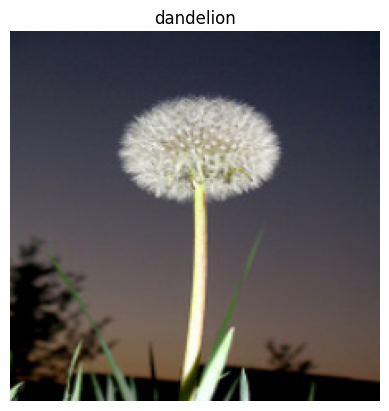

In [9]:
# Set seeds
set_seeds()

# Set image patch size
patch_size = 16

# Visualize a image
plot_an_image(train_dataloader, class_names, patch_size)

# 4. Get the model

In [10]:
set_seeds()
# 1. Get pretrained weights
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# 2. Setup the model with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:03<00:00, 115MB/s]


In [11]:
summary(model=pretrained_vit, input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20, row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 5]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

# 5. Train the model

In [12]:
# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = train(model=pretrained_vit, train_dataloader=train_dataloader, test_dataloader=test_dataloader,
                               optimizer=optimizer, loss_fn=loss_fn, epochs=10, device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7215 | train_acc: 0.7673 | test_loss: 0.4106 | test_acc: 0.8762
Epoch: 2 | train_loss: 0.3690 | train_acc: 0.8948 | test_loss: 0.3158 | test_acc: 0.8995
Epoch: 3 | train_loss: 0.2887 | train_acc: 0.9218 | test_loss: 0.2716 | test_acc: 0.9047
Epoch: 4 | train_loss: 0.2439 | train_acc: 0.9332 | test_loss: 0.2568 | test_acc: 0.9115
Epoch: 5 | train_loss: 0.2154 | train_acc: 0.9418 | test_loss: 0.2398 | test_acc: 0.9101
Epoch: 6 | train_loss: 0.1928 | train_acc: 0.9477 | test_loss: 0.2277 | test_acc: 0.9183
Epoch: 7 | train_loss: 0.1738 | train_acc: 0.9567 | test_loss: 0.2238 | test_acc: 0.9129
Epoch: 8 | train_loss: 0.1611 | train_acc: 0.9615 | test_loss: 0.2142 | test_acc: 0.9156
Epoch: 9 | train_loss: 0.1474 | train_acc: 0.9642 | test_loss: 0.2068 | test_acc: 0.9183
Epoch: 10 | train_loss: 0.1365 | train_acc: 0.9704 | test_loss: 0.2082 | test_acc: 0.9169


# 6. Evaluation

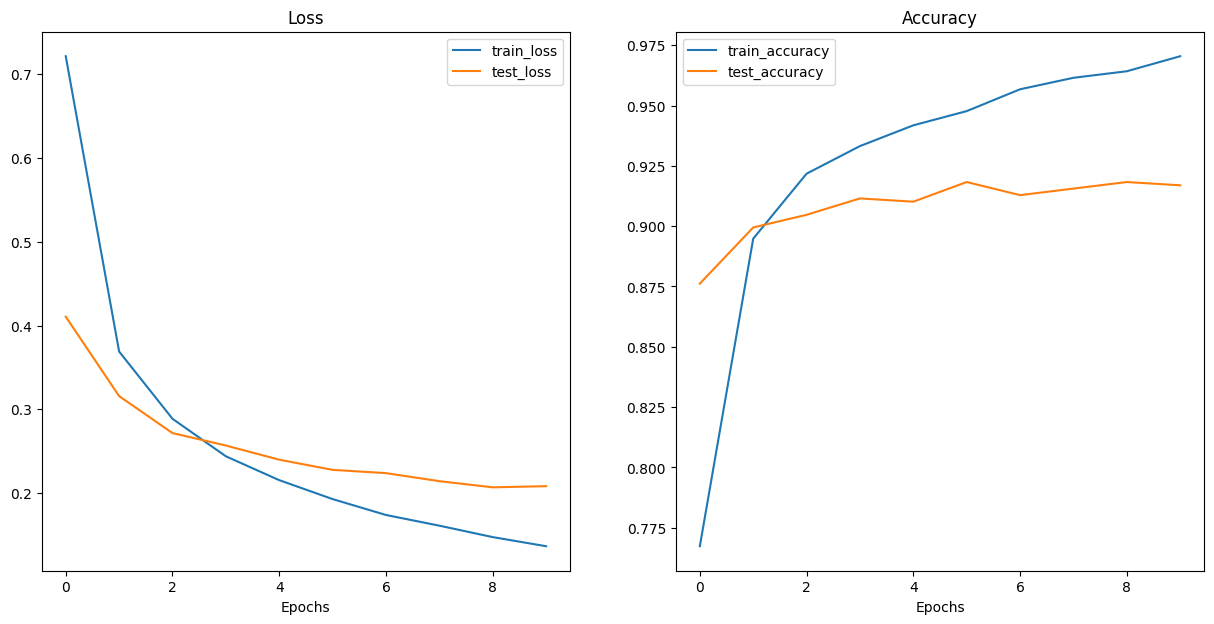

In [13]:
# Plot the losses and accs
show_losses_and_accs(pretrained_vit_results)

# 7. Predict the results

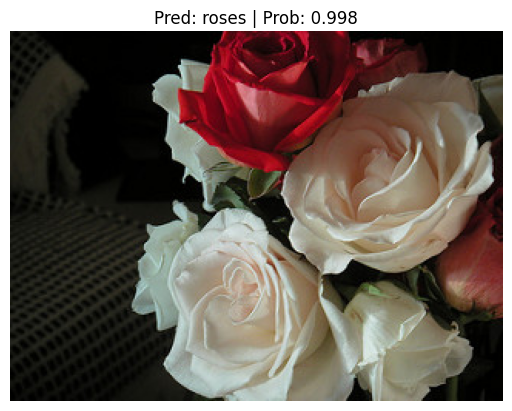

In [14]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Setup an mage path
image_path = path + "/roses/102501987_3cdb8e5394_n.jpg"
pred_and_plot_image(model=pretrained_vit, image_path=image_path, class_names=class_names)

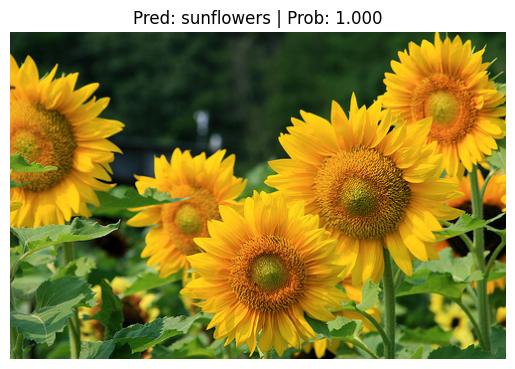

In [16]:
# Setup an image path
image_path_1 = image_path = path + "/sunflowers/1008566138_6927679c8a.jpg"
pred_and_plot_image(model=pretrained_vit, image_path=image_path_1, class_names=class_names)